In [ ]:

# 1) Instalar e importar librerías

!pip install pmdarima --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error

<ipython-input-11-616a5f2b6a5c>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_excel("tfg.xlsx", parse_dates=["trimestres"])


Primeras filas:
  trimestres     españa  turismo_internacional  exportaciones  importaciones  \
0 2000-01-01  177400000           2.146650e+09    31196000000   4.247050e+10   
1 2000-02-01  160232000           3.828565e+09    32608000000   4.226475e+10   
2 2000-03-01  163227000           5.074554e+09    31196000000   4.226475e+10   
3 2000-04-01  166992000           8.040250e+09    29784000000   4.205900e+10   
4 2001-01-01  170735000           2.283348e+09    32500000000   4.300000e+10   

   tasa_actividad         ipi  precio_petroleo  deuda_publica  
0            53.1  591.285333         31.94000   362694000000  
1            53.4  590.065333         29.75000   365743000000  
2            53.9  567.984667         28.45000   369100000000  
3            54.0  566.296667         31.22203   374557000000  
4            53.1  582.329333         28.66000   372830000000  

Resumen estadístico:
                          trimestres        españa  turismo_internacional  \
count               

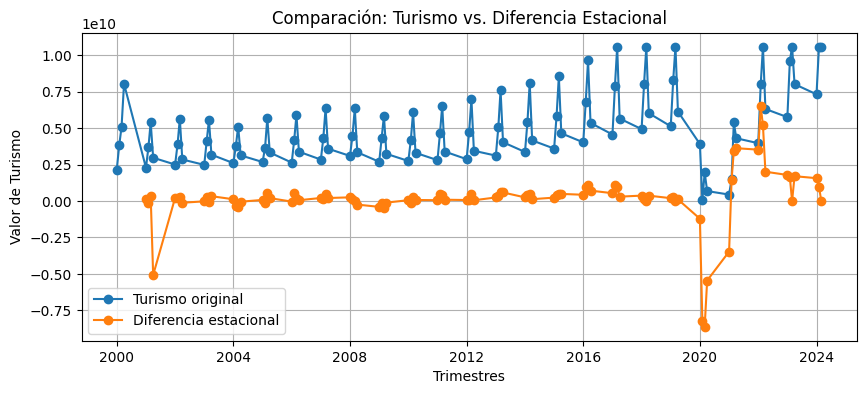

In [ ]:


# Cargar la base de datos
df = pd.read_excel("tfg.xlsx", parse_dates=["trimestres"])

# Mostrar primeras filas, resumen e información
print("Primeras filas:")
print(df.head())
print("\nResumen estadístico:")
print(df.describe())
print("\nInformación:")
print(df.info())


# Convertir la columna de fechas a índice y ordenar cronológicamente
df.set_index("trimestres", inplace=True)
df.sort_index(inplace=True)

# Verificar si hay valores nulos y, en caso afirmativo, eliminarlos
print("\nValores nulos por columna:")
print(df.isnull().sum())
df = df.dropna()  # Si los nulos son pocos; si no, aplicar imputación

# Eliminamos duplicados si existen
df = df.drop_duplicates()

# Tratamiento de outliers usando el método IQR (para las columnas numéricas relevantes)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Reemplazamos los outliers por el límite correspondiente
    df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

# variable "turismo"
# Crear una variable dummy que capture el efecto del COVID:
# Asumimos que a partir del 1 de marzo de 2020 la dinámica cambió.
df["dummy_covid"] = (df.index >= pd.Timestamp("2020-03-01")).astype(int)

# columna con diferencia estacional (lag=4, pues es trimestral).
df["turismo_seasonal_diff"] = df["turismo_internacional"].diff(4)
# Visualizar la serie para decidir si usar la original o la diferenciada.
plt.figure(figsize=(10,4))
plt.plot(df["turismo_internacional"], marker='o', label="Turismo original")
plt.plot(df["turismo_seasonal_diff"], marker='o', label="Diferencia estacional")
plt.title("Comparación: Turismo vs. Diferencia Estacional")
plt.xlabel("Trimestres")
plt.ylabel("Valor de Turismo")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Mostrar todas las filas (o el número que desees)
pd.set_option('display.max_rows', None)

# Si quieres también ver todas las columnas
pd.set_option('display.max_columns', None)

# Ahora, al imprimir df, verás todas las filas y columnas
df


,españa,turismo_internacional,exportaciones,importaciones,tasa_actividad,ipi,precio_petroleo,deuda_publica,dummy_covid,turismo_seasonal_diff
trimestres,,,,,,,,,,
2000-02-01,172385500.0,3.828565e+09,32608000000,4.226475e+10,55.345,590.065333,29.750000,365743000000,0,NaN
2000-03-01,172385500.0,5.074554e+09,31196000000,4.226475e+10,55.345,567.984667,28.450000,369100000000,0,NaN
2000-04-01,172385500.0,8.040250e+09,29784000000,4.205900e+10,55.345,566.296667,31.222030,374557000000,0,NaN
2001-01-01,172385500.0,2.283348e+09,32500000000,4.300000e+10,55.345,582.329333,28.660000,372830000000,0,1.366981e+08
2001-02-01,173291000.0,3.690192e+09,32500000000,4.300000e+10,55.345,596.807333,27.770000,377138000000,0,-1.383734e+08
2001-03-01,176927000.0,5.404509e+09,33500000000,4.300000e+10,55.345,570.707000,24.790000,378281000000,0,3.299552e+08
2001-04-01,180040000.0,2.966772e+09,32258000000,4.367700e+10,55.345,577.465333,19.800000,378883000000,0,-5.073478e+09
2002-01-01,182753000.0,2.499670e+09,32500000000,4.300000e+10,55.345,571.259667,23.410000,379002000000,0,2.163221e+08
2002-02-01,186170000.0,3.893375e+09,33000000000,4.400000e+10,55.345,584.123333,26.960000,383191000000,0,2.031831e+08


<ipython-input-14-e30075ae9d1e>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_excel("tfg.xlsx", parse_dates=["trimestres"])


Q1 = 244367500.0 , Q3 = 292355500.0 , IQR = 47988000.0
Límites para detectar outliers: 172385500.0 y 364337500.0
Estadísticas de 'españa' tras winsorización:
count    9.900000e+01
mean     2.651531e+08
std      4.937669e+07
min      1.723855e+08
25%      2.443675e+08
50%      2.673550e+08
75%      2.923555e+08
max      3.643375e+08
Name: españa, dtype: float64


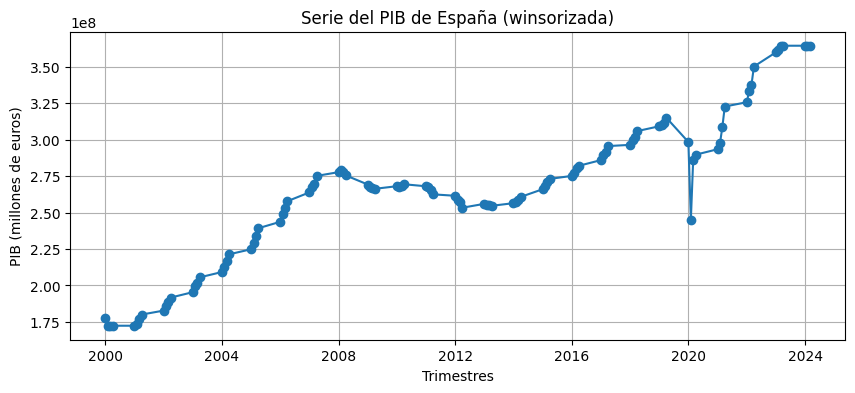

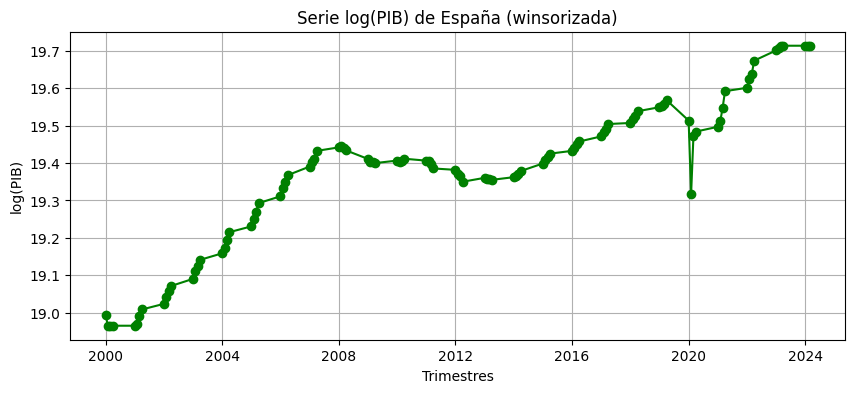

=== ADF Test sobre la 1ª diferencia (regresión 'c') ===
Estadístico: -10.9299, p-value: 0.0000
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-372.467, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-372.467, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.158 seconds
===== Modelo C: ARIMA(0,1,0) con drift =====
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 188.234
Date:                Wed, 12 Mar 2025   AIC                           -372.467
Time:                        21:20:51   BIC                           -367.468
Sample:                             0   HQIC                          -370.451
                                 - 91                                         
Covariance Type:                  opg                  

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model wi

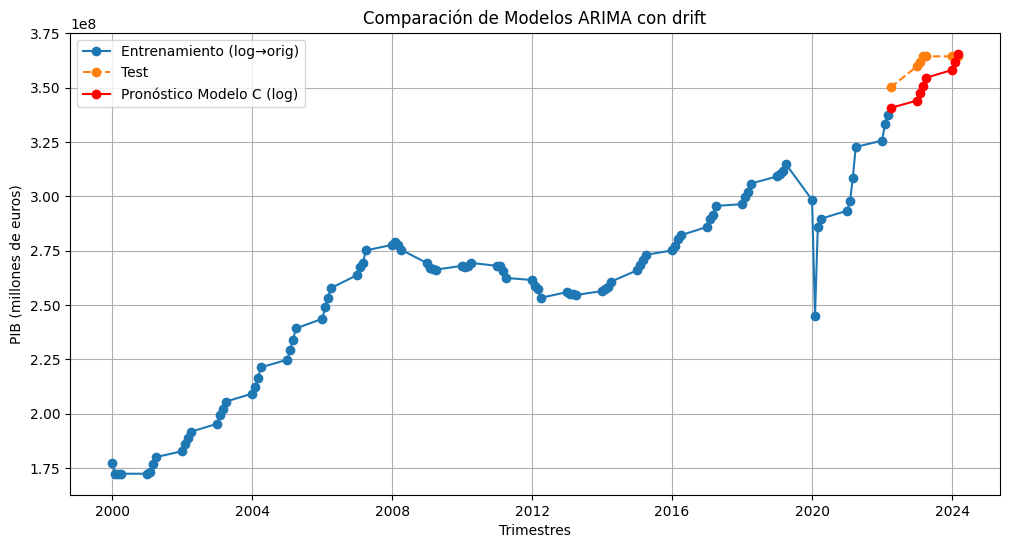

In [ ]:

# 1) Instalar e importar librerías

!pip install pmdarima --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Funciones para calcular errores
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mae, mape


# 2) Cargar y preparar los datos

df = pd.read_excel("tfg.xlsx", parse_dates=["trimestres"])
df.set_index("trimestres", inplace=True)
df.sort_index(inplace=True)

# ----- Winsorización en la variable "españa" -----
Q1 = df["españa"].quantile(0.25)
Q3 = df["españa"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("Q1 =", Q1, ", Q3 =", Q3, ", IQR =", IQR)
print("Límites para detectar outliers:", lower_bound, "y", upper_bound)

# Sustituir valores extremos (winsorización)
df["españa"] = df["españa"].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
print("Estadísticas de 'españa' tras winsorización:")
print(df["españa"].describe())

# 3) Transformar la variable objetivo a log

# Para el primer modelo (Modelo C original), aplicamos log manualmente.
y = df["españa"]

plt.figure(figsize=(10,4))
plt.plot(y, marker='o')
plt.title("Serie del PIB de España (winsorizada)")
plt.xlabel("Trimestres")
plt.ylabel("PIB (millones de euros)")
plt.grid(True)
plt.show()

y_log = np.log(y)

plt.figure(figsize=(10,4))
plt.plot(y_log, marker='o', color='green')
plt.title("Serie log(PIB) de España (winsorizada)")
plt.xlabel("Trimestres")
plt.ylabel("log(PIB)")
plt.grid(True)
plt.show()

# ============================================================
# NUEVA SECCIÓN: Verificar la estacionariedad de la serie diferenciada
# ============================================================

# Primera diferencia
y_log_diff = y_log.diff().dropna()
adf_result_diff = adfuller(y_log_diff, regression='c')
print("=== ADF Test sobre la 1ª diferencia (regresión 'c') ===")
print("Estadístico: {:.4f}, p-value: {:.4f}".format(adf_result_diff[0], adf_result_diff[1]))

# Si el p-value es mayor a 0.05, se prueba incluir un término de tendencia
if adf_result_diff[1] > 0.05:
    adf_result_diff_trend = adfuller(y_log_diff, regression='ct')
    print("=== ADF Test sobre la 1ª diferencia (regresión 'ct') ===")
    print("Estadístico: {:.4f}, p-value: {:.4f}".format(adf_result_diff_trend[0], adf_result_diff_trend[1]))

# En caso de que ambos p-values sean altos, se intenta con una segunda diferencia
if adf_result_diff[1] > 0.05 and adf_result_diff_trend[1] > 0.05:
    y_log_diff2 = y_log_diff.diff().dropna()
    adf_result_diff2 = adfuller(y_log_diff2, regression='c')
    print("=== ADF Test sobre la 2ª diferencia (regresión 'c') ===")
    print("Estadístico: {:.4f}, p-value: {:.4f}".format(adf_result_diff2[0], adf_result_diff2[1]))
# 4) División en entrenamiento y test

n_test = 8  # Usamos los últimos 8 trimestres para validación
y_train_log = y_log.iloc[:-n_test]
y_test_log  = y_log.iloc[-n_test:]
y_test_original = y.iloc[-n_test:]

# 5) Ajuste del Modelo C: ARIMA(0,1,0) con drift forzado

# Modelo C: ARIMA(0,1,0) con drift forzado
# -------------------------
model_C = pm.auto_arima(
    y_train_log,
    start_p=0, start_q=0,
    max_p=0, max_q=0,
    d=1,
    seasonal=False,
    trend='t',  # 't' fuerza la inclusión de un drift (tendencia lineal)
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)
print("===== Modelo C: ARIMA(0,1,0) con drift =====")
print(model_C.summary())

forecast_C_log = model_C.predict(n_periods=n_test)
forecast_C = np.exp(forecast_C_log)
rmse_C, mae_C, mape_C = evaluate_forecast(y_test_original, forecast_C)
print(f"Modelo C - RMSE: {rmse_C:.3f}, MAE: {mae_C:.3f}, MAPE: {mape_C:.2f}%")
print("\n")


# 7) Visualización gráfica del modelo (Modelo C)

plt.figure(figsize=(12,6))
plt.plot(y_train_log.index, np.exp(y_train_log), label="Entrenamiento (log→orig)", marker='o')
plt.plot(y_test_original.index, y_test_original, label="Test", marker='o', linestyle='--')
plt.plot(y_test_original.index, forecast_C, label="Pronóstico Modelo C (log)", marker='o', color='red')
plt.xlabel("Trimestres")
plt.ylabel("PIB (millones de euros)")
plt.title("Comparación de Modelos ARIMA con drift")
plt.legend()
plt.grid(True)
plt.show()